Modified and verified by **Heejoon Moon**
- version: 11.28

## **0. Preprocessing Data**
- concat RGB frames and opticalflow
- transform videos to '.npy' format
  - '.npy' has 5 channels -> RGB (3) and opticalflow ((u, v) -> 2)
  - you can use another opticalflow algorithms

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

def getOpticalFlow(video):
    """Calculate dense optical flow of input video
    Args:
        video: the input video with shape of [frames,height,width,channel]. dtype=np.array
    Returns:
        flows_x: the optical flow at x-axis, with the shape of [frames,height,width,channel]
        flows_y: the optical flow at y-axis, with the shape of [frames,height,width,channel]
    """
    # initialize the list of optical flows
    gray_video = []
    for i in range(len(video)):
        img = cv2.cvtColor(video[i], cv2.COLOR_RGB2GRAY)
        gray_video.append(np.reshape(img, (224, 224, 1)))

    flows = []
    for i in range(0, len(video) - 1):
        # calculate optical flow between each pair of frames
        flow = cv2.calcOpticalFlowFarneback(gray_video[i], gray_video[i + 1], None, 0.5, 3, 15, 3, 5, 1.2,
                                            cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        # subtract the mean in order to eliminate the movement of camera
        flow[..., 0] -= np.mean(flow[..., 0])
        flow[..., 1] -= np.mean(flow[..., 1])
        # normalize each component in optical flow
        flow[..., 0] = cv2.normalize(flow[..., 0], None, 0, 255, cv2.NORM_MINMAX)
        flow[..., 1] = cv2.normalize(flow[..., 1], None, 0, 255, cv2.NORM_MINMAX)
        # Add into list
        flows.append(flow)

    # Padding the last frame as empty array
    flows.append(np.zeros((224, 224, 2)))

    return np.array(flows, dtype=np.float32)


def Video2Npy(file_path, resize=(224,224)):
    """Load video and tansfer it into .npy format
    Args:
        file_path: the path of video file
        resize: the target resolution of output video
    Returns:
        frames: gray-scale video
        flows: magnitude video of optical flows
    """
    # Load video
    cap = cv2.VideoCapture(file_path)
    # Get number of frames
    len_frames = int(cap.get(7))
    # Extract frames from video
    try:
        frames = []
        for i in range(len_frames-1):
            _, frame = cap.read()
            frame = cv2.resize(frame,resize, interpolation=cv2.INTER_AREA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = np.reshape(frame, (224,224,3))
            frames.append(frame)
    except:
        print("Error: ", file_path, len_frames,i)
    finally:
        frames = np.array(frames)
        cap.release()

    # Get the optical flow of video
    flows = getOpticalFlow(frames)
    
    # Visualize optical flow map
    optical_flow_map = farneback_visual(flows)

    result = np.zeros((len(flows),224,224,5))
    result[...,:3] = frames
    result[...,3:] = flows

    return result

def farneback_visual(flows):
    # visualization farneback optical flow map
    # save the map as 'farneback_optical_flow.mp4'
    pass


def Save2Npy(file_dir, save_dir):   # modify this code to save the npy files for your directory or path
    """Transfer all the videos and save them into specified directory
    Args:
        file_dir: source folder of target videos
        save_dir: destination folder of output .npy files
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # List the files
    videos = os.listdir(file_dir)
    for v in tqdm(videos):
        # Split video name
        video_name = v.split('.')[0]
        # Get src
        video_path = os.path.join(file_dir, v)
        # Get dest
        save_path = os.path.join(save_dir, video_name+'.npy')
        # Load and preprocess video
        data = Video2Npy(file_path=video_path, resize=(224,224))
        data = np.uint8(data)
        # Save as .npy file
        np.save(save_path, data)

    return None

### convert data and save it (offline)

In [2]:
# # source_path = '?/RWF-2000 Dataset'
# # target_path = '?/npy_dataset'
# source_path = 'C:/Users/labinno/Desktop/cv_project_2/raw_video'
# target_path = 'C:/Users/labinno/Desktop/cv_project_2/npy_dataset'

# for f1 in ['train', 'val']:
#     for f2 in ['Fight', 'NonFight']:
#         path1 = os.path.join(source_path, f1, f2)
#         path2 = os.path.join(target_path, f1, f2)
#         Save2Npy(file_dir=path1, save_dir=path2)

## **1. Build Data Loader**

In [3]:
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import cv2

class DataGenerator(Dataset):
    
    ### basic function templates for Dataset class in Pytorch : __init__, __len__, __getitem__###
    def __init__(self, directory, data_augmentation=True, phase='train'):
        self.phase=phase
        self.directory = directory
        self.data_aug = data_augmentation
        self.X_path, self.Y_dict = self.search_data()
        self.print_stats()

    def __len__(self):
        steps_per_epoch = int(len(self.X_path))
        return steps_per_epoch

    # get data and label corresponding to index using 'data_generation function'
    def __getitem__(self, index):
        data, label = self.data_generation(self.X_path[index])
        return data.float(), label

    #############################################################
    # -----------------codes down from this line are provided.------------------- #
    # call raw data using data path, and data processing including 'uniform sampling', 'color jittering', 'random flip', and 'normalize'
    #############################################################
    
    def load_data(self, path):
        data = np.load(path, mmap_mode='r') # Read the raw data from path 
        data = self.uniform_sampling(data, target_frames=64) # Randomly sample number of target frames
        if self.data_aug: # If data is augmented...
            data[..., :3] = self.color_jitter(data[..., :3]) 
            data = self.random_flip(data, prob=0.5) # Random flip image into random direction
        data[..., :3] = self.normalize(data[..., :3]) # Normalize RGB
        data[..., 3:] = self.normalize(data[..., 3:]) # Normalize optical flows
        return data

    # shuffle data
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)  

    # Normalize data 
    def normalize(self, data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std

    def random_flip(self, video, prob):
        s = np.random.rand()
        if s < prob:
            video = np.flip(video, (2,)) # Flip in width direction
        return video

    def uniform_sampling(self, video, target_frames=64):
        # get total frames of input video and calculate sampling interval
        len_frames = int(len(video))
        interval = int(np.ceil(len_frames/target_frames))
        # init empty list for sampled video and
        sampled_video = []
        for i in range(0,len_frames,interval):
            sampled_video.append(video[i])
        # calculate numer of padded frames and fix it
        num_pad = target_frames - len(sampled_video) # num pad = # target frame - # current frame 
        padding = []
        if num_pad>0:
            for i in range(-num_pad,0):
                try:
                    padding.append(video[i]) # Fill with the last video frame
                except:
                    padding.append(video[0])
            sampled_video += padding # Add padding results
        # get sampled video
        return np.array(sampled_video, dtype=np.float32)

    # Jitter = spread values
    def color_jitter(self, video):
        s_jitter = np.random.uniform(-0.2, 0.2) 
        v_jitter = np.random.uniform(-30, 30)
        for i in range(len(video)):
            hsv = cv2.cvtColor(np.array(video[i]), cv2.COLOR_RGB2HSV) # Convert RGB -> HSV 
            s = hsv[..., 1] + s_jitter # saturation jitter
            v = hsv[..., 2] + v_jitter # Value jitter
            # Flip
            s[s < 0] = 0
            s[s > 1] = 1
            v[v < 0] = 0
            v[v > 255] = 255
            hsv[..., 1] = s # set jittered saturation
            hsv[..., 2] = v # Set jittered value
            video[i] = torch.Tensor(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)) # Convert HSV -> RGB again
        return video

    # print current state sof the Dataset class
    def print_stats(self):
            self.n_files = len(self.X_path)
            self.n_classes = len(self.dirs)
            self.indexes = np.arange(len(self.X_path))
            np.random.shuffle(self.indexes)
            print("Found {} files belonging to {} classes.".format(self.n_files, self.n_classes))
            for i, label in enumerate(self.dirs):
                print('{:10s} : {}'.format(label, i))    
                
    #############################################################
    # Fill the missing part of the code with functions given above
    #############################################################
    
    # get data and label(one-hot encoded) from path list/dictionary
    def search_data(self):
        X_path = []
        Y_dict = {}
        self.dirs = sorted(os.listdir(self.directory)) # Get sorted file directories
        #___________________________________________________________
        #one_hots = ###Fill here###  # One-hot encoded vector 
        one_hots = np.eye(len(self.dirs))
        #___________________________________________________________

        for i, folder in enumerate(self.dirs):
            folder_path = os.path.join(self.directory, folder)  # folder_path = ...train/Fight or ...train/NonFight
            for file in os.listdir(folder_path):
                # Add file path into X_path
                # Assign one hot encoded vector into Y_dict
                #___________________________________________________________
                file_path = os.path.join(folder_path, file)
                X_path.append(file_path)
                Y_dict[file_path] = one_hots[i]
                #___________________________________________________________
        return X_path, Y_dict
    
    # define batch x using 'load_data' function and batch_y from self.Y_dict.
    def data_generation(self, batch_path):

        #___________________________________________________________
        # batch_x = np.array(###Fill here###)
        # batch_y = np.array(###Fill here###)
        batch_x = np.array(self.load_data(batch_path))  # Load and convert the data into a numpy array
        batch_y = np.array(self.Y_dict[batch_path])     # Convert the label into a numpy array
                           
        # Transfer numpy array to tensor
        ###Fill here###
        batch_x = torch.from_numpy(batch_x).float()  # Convert batch_x to a PyTorch tensor and ensure float type
        batch_y = torch.from_numpy(batch_y).long()   # Convert batch_y to a PyTorch tensor and ensure long type for labels
        #___________________________________________________________

        return batch_x, batch_y

## **2. Build Simple Model**
- this model is 'Flow Gated Network' proposed in 'RWF2000'
- you can use off-the-shelf architectures such as ResNet, EfficientNet, etc.
- model structure is produced in below image
- Fully-Connected layer is little bit different with image, so we provide Fully-Connected layer structure

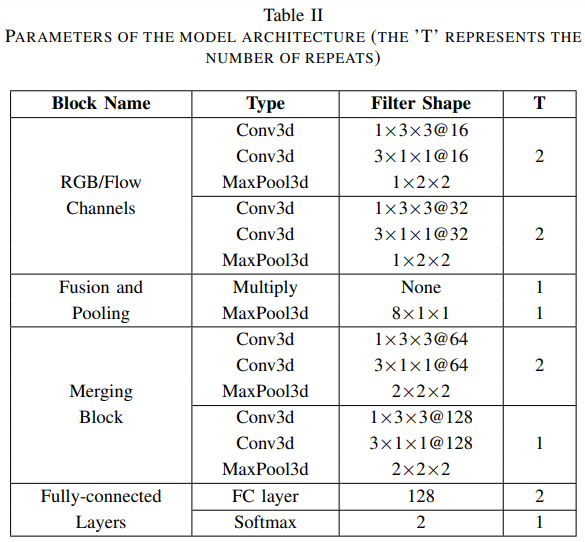

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        self.relu=nn.ReLU(inplace=True)
        
        ## Hint: Please refer to above table for constructing layers
        #______________________________________________________________________________________________________
        # Construct block of RGB layers which takes RGB channel(3) as input
      # RGB Channels
        self.rgb_conv1 = nn.Conv3d(3, 16, kernel_size=(1, 3, 3), stride=1, padding=1)
        self.rgb_bn1 = nn.BatchNorm3d(16)
        self.rgb_conv2 = nn.Conv3d(16, 32, kernel_size=(3, 1, 1), stride=1, padding=1)
        self.rgb_bn2 = nn.BatchNorm3d(32)
        #______________________________________________________________________________________________________

        # Construct block of optical flow layers which takes the optical flow channel(2) as input
        #______________________________________________________________________________________________________
          # Optical Flow Channels
        self.opt_conv1 = nn.Conv3d(2, 16, kernel_size=(1, 3, 3), stride=1, padding=1)
        self.opt_bn1 = nn.BatchNorm3d(16)
        self.opt_conv2 = nn.Conv3d(16, 32, kernel_size=(3, 1, 1), stride=1, padding=1)
        self.opt_bn2 = nn.BatchNorm3d(32)
        #______________________________________________________________________________________________________

        # Construct merging Block
        #______________________________________________________________________________________________________
        self.merging_block = nn.Sequential(
                nn.Conv3d(32, 64, kernel_size=(1, 3, 3), stride=1, padding=1),
                nn.BatchNorm3d(64),
                nn.Conv3d(64, 128, kernel_size=(3, 1, 1), stride=1, padding=1),
                nn.BatchNorm3d(128),
                nn.MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0)
            )

        #______________________________________________________________________________________________________

        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 2)
        
        # Initialize weights
        self.__init_weight()
        
    def forward(self, x):
        rgb = x[...,:3] # Seperate RGB data
        opt = x[...,3:5] # Seperate Optical flow data
        # Reshpae tensor into (#Batch, channel, dimension(#frame), height, width)
        rgb = rgb.contiguous().view(4, 3, 64, rgb.shape[2], rgb.shape[3]) # 64 is fixed number of frames
        opt = opt.contiguous().view(4, 2, 64, opt.shape[2], opt.shape[3]) 


        #______________________________________________________________________________________________________
        # Pass through the RGB data through the blocks of RGB layers
        rgb_output = F.relu(self.rgb_bn1(self.rgb_conv1(rgb)))
        rgb_output = F.relu(self.rgb_bn2(self.rgb_conv2(rgb_output)))
        # Pass through the optical flow data through the blocks of RGB layers
        opt_output = F.relu(self.opt_bn1(self.opt_conv1(opt)))
        opt_output = F.relu(self.opt_bn2(self.opt_conv2(opt_output)))

        # Fuse by performing elementwise multiplication of rgb and opt tensors. 
  
        # fused = ## fill here ##
        #fused = rgb_output * opt_output
        fused = torch.mul(rgb_output, opt_output)
        #fused = torch.cat((rgb, opt), dim=1)

        # # Perform maxpooling of fused
        # fused = ## fill here ##
        #fused = F.max_pool3d(fused, kernel_size=2, stride=2)
        
        #______________________________________________________________________________________________________
        # Pass through the fused data into merging block 
        merged = self.merging_block(fused)
        print("Shape of 'merged' tensor:", merged.shape)
        #______________________________________________________________________________________________________

        # Fully Connected Layers
        x = merged.view(merged.size(0), -1)
        print("Shape of 'flattened x' tensor:", x.shape)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x
    
    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                # Perform weight initialization ("kaiming normal")
                #______________________________________________________________________________________________________
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                #______________________________________________________________________________________________________


## **3. Training the Model**
- set hyper-parameters for training

In [5]:
# !pip install wandb

In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm import tqdm
import wandb


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # define model, optimizer and criterion
# model = 
# optimizer = 
# loss_fn = 

# trainset_path = '/train'
# validation_path = '/val'

# # define dataset and dataloader
# train_dataset = 
# val_dataset = 
# train_loader = 
# val_loader = 

#______________________________________________________________________________________________________
model = FusionModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-6, nesterov=True)
loss_fn = nn.CrossEntropyLoss()

# Define the paths to your training and validation datasets
trainset_path = 'C:/Users/labinno/Desktop/cv_project_2/npy_dataset/train'
validation_path = 'C:/Users/labinno/Desktop/cv_project_2/npy_dataset/val'

# trainset_path = 'C:/Users/labinno/Desktop/cv_project_2/raw_video/train'
# validation_path = 'C:/Users/labinno/Desktop/cv_project_2/raw_video/val'

# Assuming DataGenerator is your dataset class
train_dataset = DataGenerator(trainset_path, phase='train')
val_dataset = DataGenerator(validation_path, phase='val')

# Define DataLoader for both training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
#______________________________________________________________________________________________________


# epoch = 30
epoch = 30 
# learning rate = 0.003

# optimizer = SGD
# weight decay = 1e-6
# momentum = 0.9
# nesterov = True
# gamma = 0.7

# loss = CrossEntropy

# assign device cpu or gpu
min_loss = np.inf
        

Found 160 files belonging to 2 classes.
Fight      : 0
NonFight   : 1
Found 40 files belonging to 2 classes.
Fight      : 0
NonFight   : 1


In [7]:
class Train: #added class for trainer__________________________________________________________________________________________
    def __init__(self, model, train_loader, loss_fn, optimizer, device):
        self.model = model
        self.train_loader = train_loader
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device
    
    def _train(self):
        model.train()
        acc_temp = 0
        running_loss = 0
    #______________________________________________________________________________________________________
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            acc_temp += (predicted == target).sum().item()

    #______________________________________________________________________________________________________

        train_acc = acc_temp / len(train_loader.dataset)
        train_loss = running_loss / len(train_loader.dataset)

        return train_acc, train_loss

In [8]:
class Val: #added class for validation__________________________________________________________________________________________
    def __init__(self, model, val_loader, loss_fn, device):
        self.model = model
        self.val_loader = val_loader
        self.loss_fn = loss_fn
        self.device = device
        
    
    
    def _val(self):
        model.eval()
        with torch.no_grad():
            running_loss_val = 0
            acc_temp_val =0

            # calculate accuracy and loss on validation set
    #______________________________________________________________________________________________________
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = loss_fn(output, target)

                running_loss_val += loss.item()
                _, predicted = torch.max(output.data, 1)
                acc_temp_val += (predicted == target).sum().item()


    #______________________________________________________________________________________________________


            val_acc = acc_temp_val / len(val_loader.dataset)
            val_loss = running_loss_val / len(val_loader.dataset)

        return val_acc, val_loss

In [9]:
import random
import numpy as np

import torch, gc
gc.collect()
torch.cuda.empty_cache()


seed=0
random.seed(seed)
np.random.seed(seed)
device='cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)
if device =='cuda':
    print('gpu device is using')
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

wandb.login()
wandb.init(project='computer vision', name='RWF2000')

trainer = Train(model, train_loader, loss_fn, optimizer, device)
validator = Val(model, val_loader, loss_fn, device)


for epoch in range(epoch):
    # Perform training and validation
    # Save the weights
    # Log the training and validation results
    #______________________________________________________________________________________________________
    train_loss, train_accuracy = trainer._train()
    
    # Call the validation function
    val_loss, val_accuracy = validator._val()   
    
    scheduler.step()

    # Log training and validation results to wandb
    wandb.log({'Epoch': epoch, 'Train Loss': train_loss, 'Train Accuracy': train_accuracy,
               'Val Loss': val_loss, 'Val Accuracy': val_accuracy})

    # Save model weights based on validation loss
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model.state_dict(), 'model_best.pth')

# Close wandb run
wandb.finish()

#______________________________________________________________________________________________________






Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


gpu device is using


wandb: Currently logged in as: hyunseokoh5403. Use `wandb login --relogin` to force relogin


OutOfMemoryError: CUDA out of memory. Tried to allocate 13.49 GiB. GPU 0 has a total capacty of 11.00 GiB of which 0 bytes is free. Of the allocated memory 36.60 GiB is allocated by PyTorch, and 1.65 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# best_model = './FusionModel_26.pth'
# test_path = '../data/npy_dataset_sampled_10/test'

best_model = 'C:/Users/labinno/Desktop/cv_project_2/model_best.pth'
#test_path = 'C:/Users/labinno/Desktop/cv_project_2/npy_dataset/val'
test_path = 'C:/Users/labinno/Desktop/cv_project_2/raw_video/test'

test_dataset = DataGenerator(directory=test_path, data_augmentation=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)

Found 20 files belonging to 2 classes.
Fight      : 0
NonFight   : 1


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

model.load_state_dict(torch.load(best_model))
model.eval()

#______________________________________________________________________________________________________
# Prepare to accumulate predictions and targets
all_preds = []
all_targets = []

# Evaluate the model
correct = 0
total = 0
#______________________________________________________________________________________________________

with torch.no_grad():
    # calculate accuracy and AUROC on test set
    # print accuracy
    # plot AUROC
    
    for data, target in test_loader:
        # Move data to the appropriate device
        data, target = data.to(device), target.to(device)

        # Get model outputs
        outputs = model(data)

        # Convert outputs to probabilities using softmax
        probabilities = nn.functional.softmax(outputs, dim=1)

        # Store predictions (probabilities) and actual targets for AUROC calculation
        all_preds.extend(probabilities[:, 1].cpu().numpy())  # Assuming the positive class is at index 1
        all_targets.extend(target.cpu().numpy())

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

# Calculate overall accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate AUROC
auroc_score = roc_auc_score(all_targets, all_preds)
print(f'AUROC: {auroc_score:.4f}')

# Calculate ROC curve
fpr, tpr, _ = roc_curve(all_targets, all_preds)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

ValueError: Cannot load file containing pickled data when allow_pickle=False